# **A Decade of NBA Team Leaders: Data Analysis from 2014‑15 to 2024‑25**

##**Introduction**

Over the past decade, the NBA has seen significant changes in playing style and player performance. This project analyzes data on leading NBA players from the 2014‑15 season through 2024‑25, spanning both regular seasons and playoffs. As an NBA fan aspiring to a career in data analytics, I undertook this project to practice data gathering, visualization, and predictive modeling on a topic I’m passionate about. The goal is to examine **how the game has evolved over the last 10+ years** and to derive insights about player performance trends. Additionally, simple predictive models are built to explore forecasting of player stats (like scoring) and even to attempt predicting award outcomes (MVP), demonstrating analytical skills and identifying areas for further improvement.

**Data Overview**: The dataset was collected from the official NBA stats website via their API. For each season from 2014–15 to 2024–25, both regular season and playoff data were retrieved. The data includes **comprehensive player statistics** (games played, minutes, field goals, rebounds, assists, etc.) for the top-performing players in each season. In total, the dataset contains over 8,000 player-season entries, covering virtually all players who registered significant stats in those seasons (essentially the league leaders in scoring for each year, which tends to include each team’s primary contributors). Key fields in the data include: player name, team, season, minutes played, points, rebounds, assists, steals, blocks, and shooting totals (with percentages), among others. This rich dataset enables a broad analysis of player performance and trends over time.

**Tools & Methods**: The project was executed in Python, utilizing libraries such as `pandas` for data manipulation, `matplotlib/seaborn` for visualization, and `plotly` for interactive charts. The workflow included:

1.   **Data collection via web scraping** the NBA stats API
2.   **Data cleaning and feature engineering** (calculating additional metrics)
3.   **Exploratory Data Analysis** (correlation analysis, distribution plots, trend lines)
4.   **Predictive modeling** using scikit-learn for regression and classification tasks.

Below, we detail each step and the findings.

# **Data Collection (Web Scraping NBA Stats)**

Data was collected using the official NBA league leaders API endpoint for each season and for both season types (Regular Season and Playoffs). The Python script nba_da.py sends HTTP requests to the stats API, parses the JSON responses, and appends the results into a master DataFrame. An excerpt of the data collection code is shown below:

In [ ]:
import requests
import pandas as pd
import time

# Define parameters for seasons and season types
season_types = ["Regular%20Season", "Playoffs"]
years = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']

# Prepare DataFrame with appropriate column headers
test_url = "https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season=2014-15&SeasonType=Playoffs&StatCategory=PTS"
r = requests.get(test_url, headers=headers).json()
table_headers = r['resultSet']['headers']
df_colnames = ['Year', 'Season_Type'] + table_headers
df = pd.DataFrame(columns=df_colnames)

# Loop over each season and season type to fetch data
for year in years:
    for stype in season_types:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=S&Season={year}&SeasonType={stype}&StatCategory=PTS"
        r = requests.get(url, headers=headers).json()
        df_temp = pd.DataFrame(r['resultSet']['rowSet'], columns=table_headers)
        df_temp.insert(0, 'Season_Type', stype)  # add season type and year columns
        df_temp.insert(0, 'Year', year)
        df = pd.concat([df, df_temp], ignore_index=True)
        print(f"Done: {year} {stype}")
        time.sleep(np.random.uniform(5, 40))  # polite delay to avoid rate-limits

df.to_excel('nba_player_data.xlsx', index=False)

In the above code, we query the `leagueLeaders` endpoint for points (`StatCategory=PTS`) which returns a list of players sorted by total points for that season. We did this for each season from 2014–15 to 2024–25, and for both "Regular Season" and "Playoffs". The results were combined into one DataFrame and saved to an Excel file `nba_player_data.xlsx`. The dataset thus contains player statistics for the top scorers of each season (which effectively covers each team’s leading scorer and other high-impact players).

Notably, to avoid being blocked by the NBA API, a custom header (including a User-Agent string) was used, and a random delay was introduced between requests. This ensured the scraping process was courteous and successful in retrieving data for all 22 combinations of season and season type. The final dataset has 30 columns, including identifiers (`PLAYER_ID`, `TEAM_ID`), performance metrics (points, rebounds, assists, etc.), and some pre-calculated ratios provided by the API (such as assist/turnover ratio). For analysis, we dropped a few unneeded fields (like rank and an efficiency rating) and standardized the `Season_Type` labels (replacing "`Regular%20Season`" with "`Regular Season`" for readability).

# **Data Preparation and Feature Engineering**

Before diving into analysis, some **data cleaning and feature engineering** steps were performed:

* **Filtering and Splitting**:
    * We separated the data by season type into rs_df (regular seasons) and po_df (playoffs) for certain comparative analyses.
    * We also ensured to use only meaningful entries; for example, in some analyses we filtered out players with very low minutes to avoid skewing results with negligible samples (e.g., excluding players with 60 total minutes in a season for certain rate calculations).
* **Derived Metrics**: Using the raw stats, we computed additional performance metrics for deeper insight. For each player-season, we calculated shooting percentages and other rates.
    * For example, field goal percentage, 3-point percentage, free-throw percentage, the share of shots that are 3-pointers, etc. Many of these are straightforward ratios of existing columns.
    * We also computed per-minute and per-possession metrics to normalize for pace and playing time. Key formulas used include:
        * **Per-Game/Per-48 Minutes**: To compare stats across seasons fairly, we often converted totals into per-game values. For league aggregates, we scaled totals by the number of team-games (using total minutes played, since each game = 48 minutes × 5 players per team). Similarly, to get per-48-minute rates (the length of a full game), we used each player’s minutes: e.g. stat_per_48 = (stat_total / MIN) * 48.
        * **Per 100 Possessions**: We estimated total possessions using the formula Possessions ≈ FGA + 0.44*FTA + TOV – OREB (a standard approximation). This allows calculation of stats per 100 possessions, which is a tempo-free metric. For instance, PTS_per100 = (PTS / Possessions) * 100 gives points scored per 100 possessions.
        * **Advanced Ratios**: We added metrics like True Shooting Percentage (TS%), which measures scoring efficiency accounting for 3s and free throws (TS% = PTS / [2 * (FGA + 0.44*FTA)]), and assist-to-turnover ratio (AST_TOV = AST / TOV). These metrics help capture shooting efficiency and ball-handling effectiveness beyond raw totals.
Below is a snippet illustrating how some of these features were created for the aggregated league data (summing all player stats by season) and for per-possession normalization:
```

In [ ]:
col_for_ana = ['MIN','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS']
# Aggregate total stats by season (for regular season league totals)
league = rs_df.groupby('Season_start_year')[col_for_ana].sum().reset_index()
league['Possessions'] = league['FGA'] + 0.44*league['FTA'] + league['TOV'] - league['OREB']
league['FG%']   = league['FGM'] / league['FGA']
league['3P%']   = league['FG3M'] / league['FG3A']
league['PTS/FGA'] = league['PTS'] / league['FGA']
league['AST_TOV'] = league['AST'] / league['TOV']
league['TS%']   = league['PTS'] / (2 * (league['FGA'] + 0.44*league['FTA']))
# ... etc ...
# Convert to per-100-possessions rates
for col in ['PTS','FGA','FG3A','FTA','REB','AST','STL','BLK','TOV','PF']:
    league[col] = 100 * league[col] / league['Possessions']

The above code computes league-wide shooting percentages and then converts raw totals into **per-100 possession rates** for key stats, enabling direct comparisons across seasons even as pace changes. Similar calculations were done at the individual player level (e.g., per-minute stats for correlation analysis). After feature engineering, our data was ready for exploration.

# **Exploratory Analysis and Visualization**

##**Stats Correlation Matrix**

To understand relationships between different statistical categories, we first examined the correlation matrix of player stats. Focusing on regular-season performance, we took all players (filtering out those with extremely low minutes) and computed per-minute rates for each stat to put players on an equal footing. We then looked at Pearson correlation coefficients between metrics like points, assists, rebounds, etc.

*   **Correlation heatmap of major statistical metrics for top players (per-minute basis)**. Cell values indicate Pearson correlation coefficients between the stat categories. Red tones signify a strong positive correlation, blue tones indicate negative correlation.
    *   As expected, many offensive statistics correlate strongly: for example, points (PTS) show high correlation with field goals made (FGM) and attempted (FGA), since scoring more points requires taking and making more shots.
    *   Rebounds (REB) correlate highly with defensive rebounds (DREB) and offensive rebounds (OREB) – essentially, these measure similar skills.
    *   Turnovers (TOV) have a mild positive correlation with assists (AST), indicating that primary playmakers tend to accumulate both assists and turnovers.
    *   Meanwhile, the proportion of three-point shots (FG3A%) shows a slight negative correlation with field goal percentage (FG%), hinting that players who take a high volume of threes often have lower overall shooting percentage.

*   **Insights from the correlation analysis**:
    *   Scoring (PTS) is naturally tied to shot volume (FGA) – the more shots a player takes, the more points they tend to score (with correlation ≈0.9 between PTS and FGA).
    *   Assists and rebounds are relatively independent of each other (low correlation), reflecting that playmaking and rebounding are distinct roles.
    *   Interestingly, True Shooting% (TS%) has a moderate positive correlation with 3P% and FT%, implying efficient scorers tend to be good shooters from distance and the foul line.

This correlation matrix helped confirm our expectations and guided which stats to focus on in subsequent trend analysis.
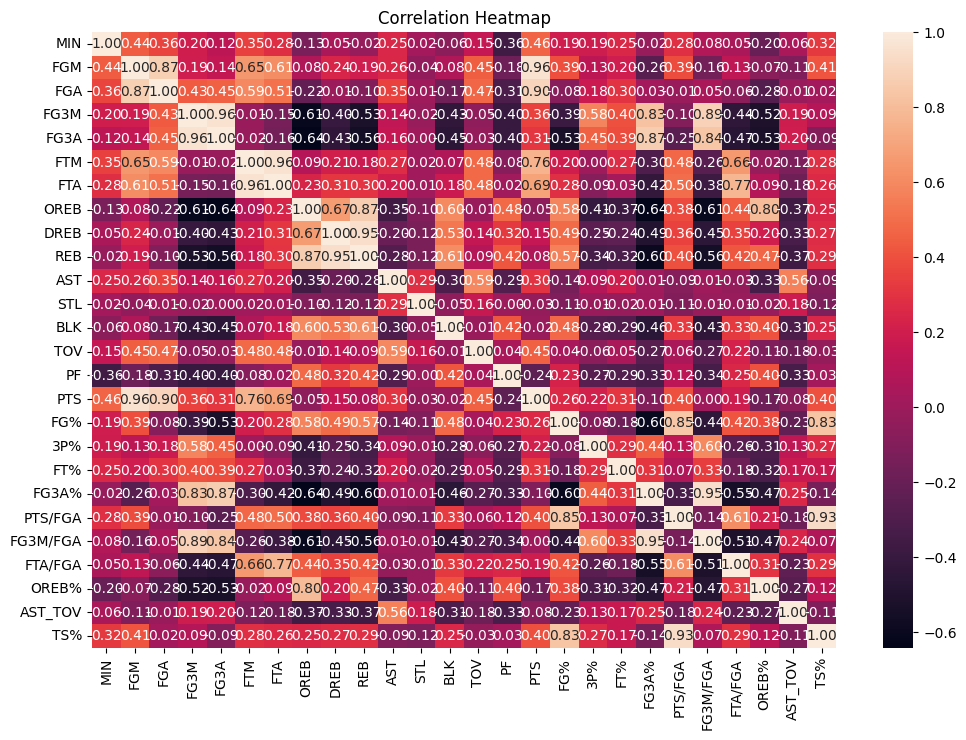


## **Playing Time Distribution: Regular Season vs Playoffs**

Next, we analyzed how player playing time differs between the regular season and playoffs. Intuitively, in the playoffs, teams rely more on their star players, leading to heavier minutes for top players, whereas in the regular season coaches use deeper rotations.

*   **Distribution of player minutes per game in regular seasons (blue) vs. playoffs (red) over the period 2015–2025**. The histogram is normalized to percentage of players.
    *   We see that the playoff distribution skews to the right – a greater share of players average high minutes (e.g. 30–40 minutes per game) in the playoffs compared to the regular season.
    *   In the regular season, many players (bench contributors) log more modest minutes per game (10–20 minutes), as indicated by the larger blue bars in the lower range.

This confirms that star players carry a heavier load in the postseason, while regular season games feature more rotation and rest. In numbers, the average minutes per game for top players is higher in playoffs. The overlap region in the histogram shows there are players in regular season with high minutes too (the top stars), but the proportion of such high-minute players is clearly higher in playoffs. This finding quantifies the coaching strategy: come playoff time, bench usage shortens and the key players see a bump in playing time. It also justifies our approach of separating regular vs playoff data for some analyses, as the context of performance can differ.
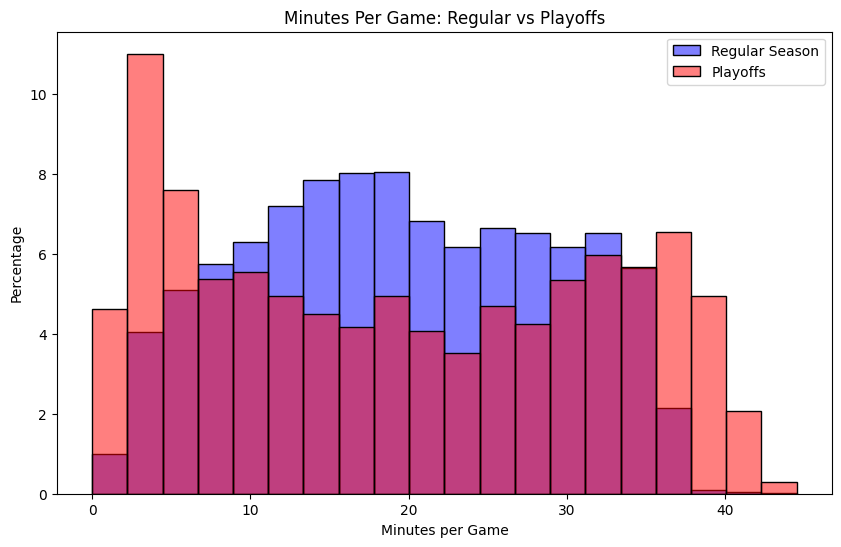


## **How the Game Has Changed (2014–2024 Trends)**

One of the core questions was: How has NBA basketball evolved over the last decade? Using our aggregated data by season, we examined league-wide trends in scoring, shooting, and pace. Two clear trends emerged: increased scoring and increased three-point shooting.

*   **The chart below illustrates these changes**: Left: Average team points per game (PPG) by season. Right: Three-point attempt rate (3PA Rate) by season, i.e. the percentage of total shot attempts that are three-pointers. Both metrics are for regular seasons 2014–15 through 2024–25.
    *   We observe a steady rise in scoring starting around 2016, with league-average PPG climbing from about 99 in 2014–15 to roughly 113 by 2020–2022.
    *   The 3-point revolution is even more pronounced: only ~26% of shots were 3-pointers in 2014–15, whereas by 2024–25 that number exceeded 40%. This indicates a dramatic shift in offensive strategy toward the three-point shot.

*   **Factors contributing to higher scoring**:
    *   Increased pace of play and emphasis on efficiency. Our data shows that game pace (estimated possessions per game) also quickened (from ~96 possessions per team per game in 2014 to around 100+ in recent years).
    *   Additionally, True Shooting Percentage (a measure of scoring efficiency) improved from ~53% to ~57-58% over the decade, meaning players (and shot selection) have become more efficient at converting possessions into points.
    *   The higher 3PA rate ties into this, as three-point shots yield higher points per attempt and teams have embraced them to boost offensive efficiency.

*   **Other subtle trends**:
    *   Assists per game league-wide have increased slightly (reflecting more ball movement and perhaps the impact of more three-point shots generating assists).
    *   Offensive rebounding has declined (as more shots are taken from the perimeter, leading to longer rebounds and fewer traditional put-back opportunities).

Overall, the data vividly captures the modern NBA’s shift toward pace-and-space, three-point-heavy offense.

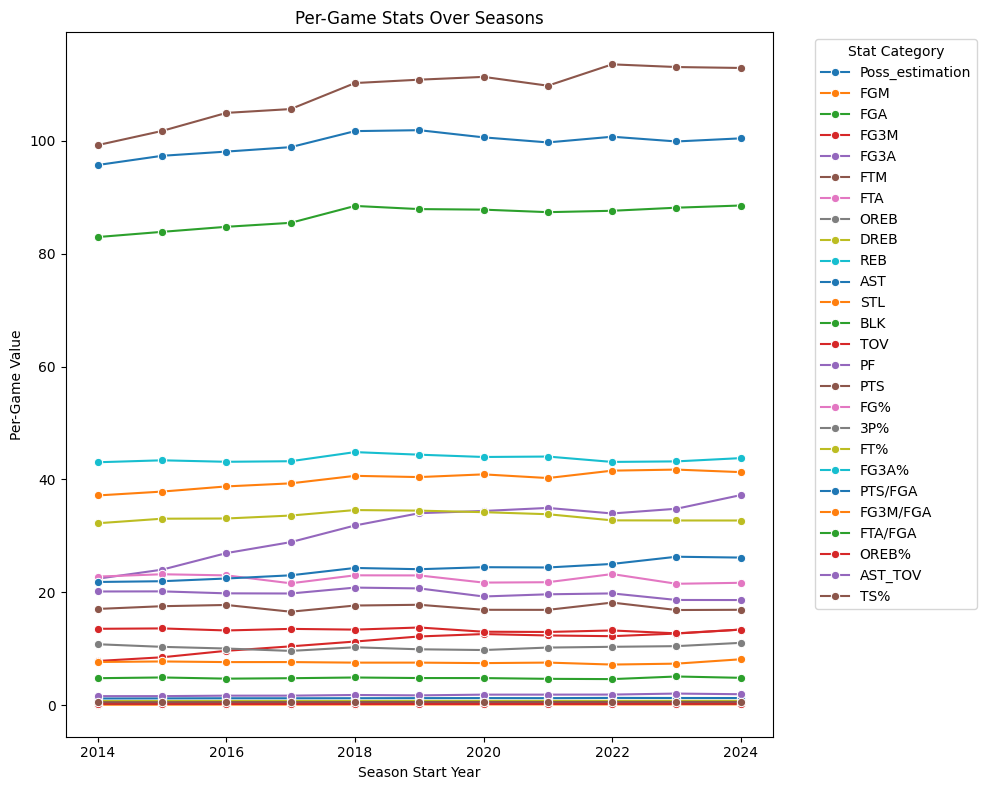
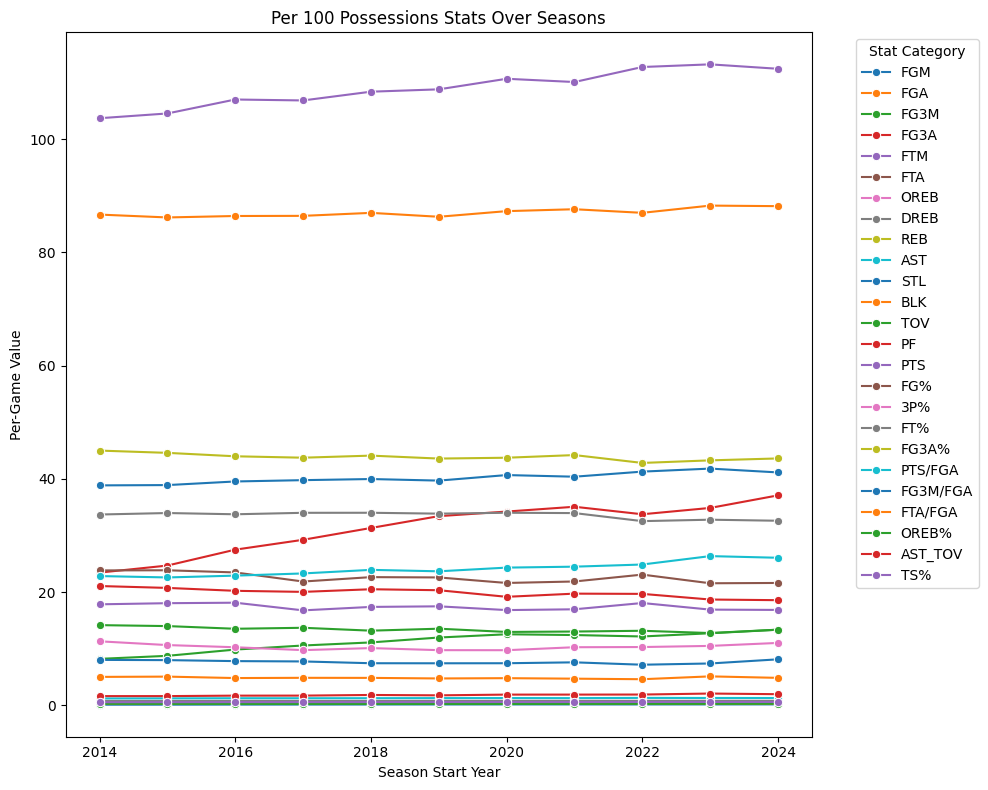

## **Regular Season vs Playoffs: Style Differences**

Building on the earlier comparison of minutes, we also asked: Do gameplay stats differ between regular season and playoffs? Using per-possession metrics (to account for pace differences), we compared key statistics in the playoffs against the regular season for each year. We computed the percentage difference for playoffs relative to regular season in stats such as scoring rate, shooting efficiency, etc.

*   **The analysis revealed a few consistent patterns**:
    *   In playoffs, scoring and efficiency tend to dip slightly while defensive stats (like blocks and steals) tick up, although year-to-year fluctuations exist. This likely reflects the tougher defenses and slower pace in postseason play.
    *   For example, across most seasons, points per 100 possessions in playoffs were a bit lower than in regular season (often a few percent less), and field goal percentages dropped in playoffs – indicating stingier defense.
    *   On the other hand, stats like blocks showed a slight increase in playoffs (players contesting shots more aggressively).

These differences, while not huge in magnitude, underscore how the style of play tightens in the postseason. Teams face elite competition and often play more half-court offense, which can reduce scoring efficiency.
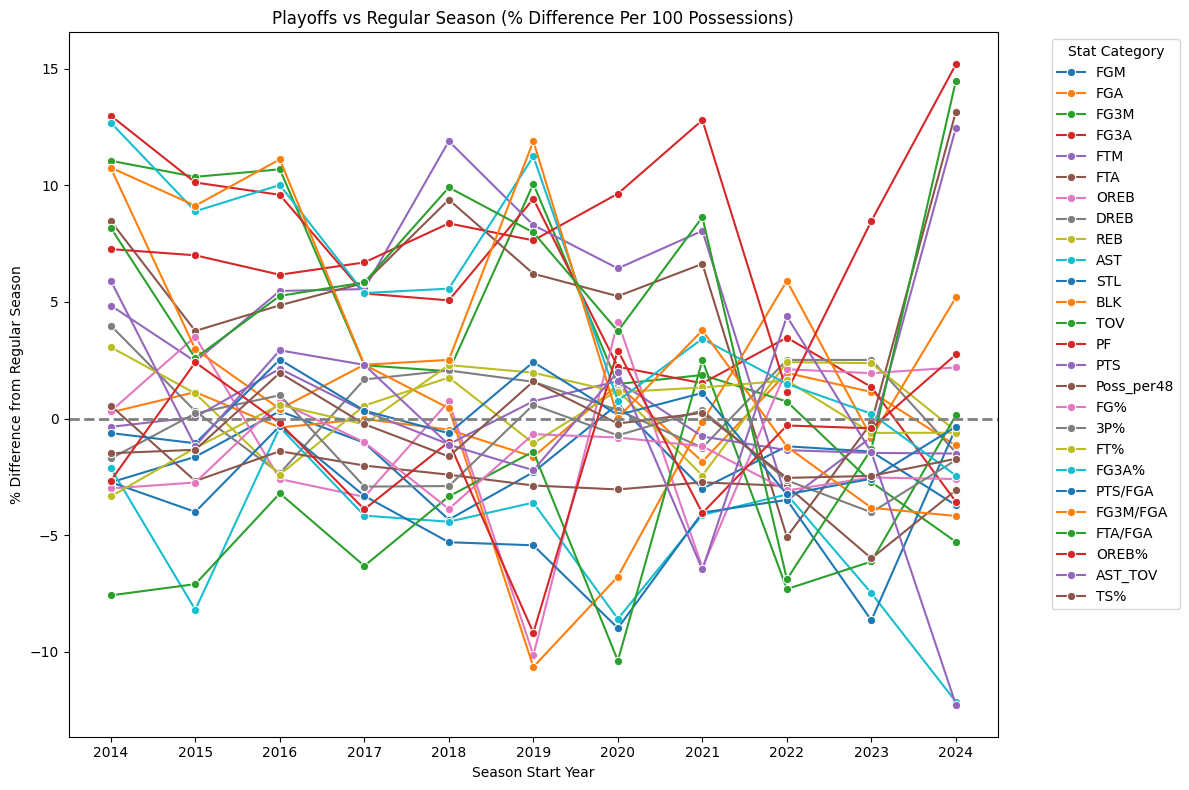

*(Interactive charts were also created in this project to visualize these trends dynamically. Using Plotly, we built a dropdown-enabled line chart allowing toggling between stats like PPG, Pace, 3PA Rate, and TS% over seasons. Another interactive chart let us select specific superstar players and see their points-per-game trajectory across the years. These tools made it easy to explore the data, though for the purposes of this report we focus on static visualizations and findings.)*

# **Predictive Modeling**

In the final part of the project, we applied simple machine learning models to explore predictive questions. Two scenarios were considered: **predicting a player’s next-season scoring** and **predicting the next season’s MVP**. These exercises showcase how we can derive additional insights and also highlight the challenges in prediction.

##**Predicting Next Season’s Scoring (Regression)**
Player performance can fluctuate year to year. We attempted to predict how a player’s scoring might change in the next season using a regression model. We constructed a dataset where each record represents a player’s season, with features based on that season’s performance and the target being the *player’s points per game (PPG) in the following season*. Only players who played in consecutive seasons are included (we drop the final season of each player since we don’t have their “next” season). The features we used were **current PPG, APG (assists per game), and RPG (rebounds per game)** – a simple set of variables capturing a player’s offensive role.

To prepare this data, we sorted each player’s seasons in chronological order and shifted their PPG forward one row to serve as the prediction target. The code snippet below shows how the feature matrix X and target y were derived:

In [ ]:
def prepare_next_season_ppg(data):
    df = data[data['Season_Type'] == 'Regular Season'].copy()
    df['PPG'] = df['PTS'] / df['GP']   # points per game this season
    df['APG'] = df['AST'] / df['GP']   # assists per game
    df['RPG'] = df['REB'] / df['GP']   # rebounds per game
    df['Season_start_year'] = df['Year'].str[:4].astype(int)
    df.sort_values(['PLAYER', 'Season_start_year'], inplace=True)
    df['Next_PPG'] = df.groupby('PLAYER')['PPG'].shift(-1)  # next season's PPG
    df_model = df.dropna(subset=['Next_PPG'])
    X = df_model[['PPG', 'APG', 'RPG']]
    y = df_model['Next_PPG']
    return X, y

X, y = prepare_next_season_ppg(data)

We then split this dataset into training and test sets (80/20 split) and trained two regression models: a **simple Linear Regression** and a **Random Forest Regressor**. The linear model provided an equation of Next_PPG as a function of current PPG/APG/RPG, while the random forest could capture any nonlinear patterns.

* **Results**: The linear regression performed surprisingly well, explaining about **75% of the variance (R² ~0.75) in next-season PPG** on the test set. The learned coefficients indicated that a player’s current scoring is by far the strongest predictor of next year’s scoring (coefficient ~0.91 for PPG), while current assists and rebounds had very little impact (their coefficients were near zero). This makes intuitive sense – a player who averages 25 points today is likely to be a high scorer next year too, assuming health and role remain similar. The small negative coefficient on rebounds, for instance, might suggest that players who rebound a lot (perhaps big men) don’t typically increase their scoring, but the effect was negligible. The Random Forest regressor achieved a similar performance (R² ~0.73) and also pointed to PPG as the most important feature by far (accounting for ~84% of the model’s decision importance, versus ~8% each for APG and RPG).

In summary, we can **predict next season’s scoring moderately well using current season stats**, but largely one’s scoring carries over. To improve the model, we could incorporate more features (e.g., age of the player, changes in team or minutes, injuries) – factors that often cause year-to-year performance changes. Nonetheless, this exercise demonstrates the workflow of preparing a dataset and applying predictive modeling in sports analytics.


##**Predicting the MVP (Classification)**

As a more ambitious (and experimental) task, we tried to predict which player would win the **Most Valuable Player (MVP)** award in the next season, based on current season data. We treated this as a binary classification: for each player-season, label it as 1 if that player ends up winning the MVP in the following season. For example, for the 2015–16 season data, Russell Westbrook’s entry would be labeled 1 because he won the MVP in 2016–17. We manually compiled the list of MVP winners from 2015 through 2023 to create the labels. Only regular season stats were considered for obvious reasons (MVP is a regular-season award).

We used the same three features (PPG, APG, RPG) for each player, hoping to see if MVPs distinguish themselves in box score stats. A **Random Forest Classifier** was trained on data up to the 2021–22 season to predict the 2022–23 MVP (which was Joel Embiid). We took care to use stratified sampling in train/test split, since the classes are extremely imbalanced (only one MVP among hundreds of players each year).

* **Results**: Not surprisingly, this prediction task proved very difficult. The model achieved a high overall accuracy (~99%) on the test set, but this is misleading because it simply learned to predict “no MVP” for everyone – the **MVP cases are exceedingly rare** (roughly 1 out of 500+ players each year). In fact, the classifier did not correctly identify the single MVP in the test data at all, yielding precision/recall of 0 for the positive class. This outcome underscores the challenge: with so few positive examples, and using only basic stats, the model had no real signal to learn who will be MVP. Most MVP winners are indeed top scorers, but not every top scorer becomes MVP (team success and narrative play big roles, which are not captured in our features). The feature importance from the Random Forest suggested that points and assists were about equally valued in whatever splits it tried, which perhaps hints that MVPs tend to excel in both scoring and playmaking, but again the model did not have enough to go on.

This experiment highlights an important lesson in data science: **class imbalance and unobserved factors** can render a predictive model ineffective. To improve MVP prediction, one would need a far richer feature set (e.g., team record, advanced efficiency metrics, perhaps media sentiment or previous awards) and likely a different modeling approach or re-framing of the problem (since predicting a single award winner out of hundreds might be better approached as a ranking problem rather than binary classification).

# **Player Archetype Clustering**

To uncover underlying “roles” or archetypes among NBA players from 2014–15 to 2024–25, we apply **K-Means clustering** to each player’s per-game stat profile and visualize the result via **PCA**. This reveals groups such as superstars, rim protectors, sharpshooters, and role players.

**Steps:**

1. **Aggregate & filter**  
   - Sum each player’s totals across all seasons  
   - Require ≥60 total games to ensure a stable sample  
   - Compute per-game averages:  
     - `PPG`, `APG`, `RPG`, `BPG`, `3PA_per_game`

2. **Scale features** with `StandardScaler` so each stat contributes equally.

3. **Choose k** by plotting  
   - **Elbow curve** (inertia vs. k)  
   - **Silhouette scores** (separation vs. k)  
   - Often `k=4` balances cohesion and interpretability.

4. **Run KMeans** (`n_clusters=4`) and assign each player to a cluster.

5. **Visualize** in 2D with PCA:

   ```python
   # after clustering...
   pca = PCA(n_components=2, random_state=42)
   coords = pca.fit_transform(X_scaled)
   player_stats['PC1'], player_stats['PC2'] = coords[:,0], coords[:,1]

   plt.figure(figsize=(8,6))
   sns.scatterplot(data=player_stats, x='PC1', y='PC2',
                   hue='Cluster', palette='tab10', s=50, alpha=0.7)
   plt.title('Player Archetypes via PCA (k=4)')
   plt.xlabel('PC1')
   plt.ylabel('PC2')
   plt.legend(title='Cluster')
   plt.tight_layout()
   plt.show()

6. **Interpret centroids**(unscaled per-game stats for each cluster) and list example players:
   ```python
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=['PPG','APG','RPG','BPG','3PA_pg']
)
centroids['Cluster'] = range(4)
print("Cluster centroids (per-game stats):\n", centroids.set_index('Cluster'))

for c in range(4):
    sample = player_stats[player_stats['Cluster']==c]['PLAYER'].sample(5, random_state=42).tolist()
    print(f"Cluster {c} examples:", sample)

# **Conclusion and Future Work**

Through this project, we compiled a comprehensive dataset of NBA team leaders and top performers over an 11-year span and derived insights about the evolution of the game. We confirmed quantitatively that the NBA has become a **faster-paced, three-point-centric league** with higher scoring and efficiency than a decade ago. We also observed how player usage intensifies in the playoffs, and how certain stats correlate with each other, painting a picture of player roles (for instance, high scorers often also commit more turnovers due to handling the offense more).

From a career development perspective, this project was a valuable exercise in the end-to-end data analysis process: **web scraping** from an official source, handling data cleaning issues, creating visualizations to tell a story, and building **simple predictive models**. Each step provided learning opportunities – for example, dealing with API rate limits during scraping, or handling imbalanced data in classification.

**Future directions**: There are several ways to extend or deepen this analysis. One idea is to incorporate more advanced metrics (like **PER, BPM, or plus/minus statistics**) to see how they trend and correlate with the basic stats.

Overall, this project not only yields interesting findings about NBA trends for fans and analysts, but also showcases my ability to apply data analytics techniques to a real-world dataset. It demonstrates initiative in self-directed work – collecting raw data and extracting meaning from it – which is an experience that will be valuable in graduate studies and beyond. The NBA will continue to evolve, and similarly, this analysis can evolve with new data, more questions, and more sophisticated methods, blending my passion for basketball with the power of data science.